In [17]:

import pandas as pd
def map_variable(
    val_or_series,
    mapping = None,
    nulls = None,
    keep = None,
    type_check = int
):
    # Deal with int-as-str issue, although I think low_memory=False should prevent this
    if keep:
        keep += [str(v) for v in keep if isinstance(v, int)]
    if nulls:
        nulls += [str(v) for v in nulls if isinstance(v, int)]
    if mapping:
        for k in list(mapping.keys()):
            if isinstance(k, int):
                mapping[str(k)] = mapping[k]

    def map_val(val):
        if pd.isna(val) or val == " ":
            return pd.NA
            #return None
        if nulls is not None and val in nulls:
            return pd.NA
            #return None
        elif keep is not None:
            if val in keep:
                return type_check(val)
            else:
                return pd.NA
                #return None
        elif mapping is not None:
            if val in mapping:
                return type_check(mapping[val])
            else:
                if nulls is not None: # assume that if we provided explicit nulls, nothing *else* maps to null
                    return type_check(val)
                else:
                    return pd.NA # otherwise, everything else maps to null; pass nulls = {} to avoid this
                    #return None
        else:
            return type_check(val)
        
    if isinstance(val_or_series, pd.Series):
        return val_or_series.apply(map_val)
    else:
        return map_val(val_or_series)
    


def validate_variable(df_var, values=None, min=None, max=None):
    distinct_values = df_var.dropna().unique()
    if len(distinct_values) == 0:
        raise ValueError("No non-missing values to validate in variable!")
    for val in distinct_values:
        if values is not None:
            if val not in values:
                raise ValueError(f"Value {val} not in allowed set of {values}")
        if min is not None:
            if val < min:
                raise ValueError(f"Value {val} less than minimum of {min}")
        if max is not None:
            if val > max:
                raise ValueError(f"Value {val} greater than maximum of {max}")
    return True

def json_to_kwargs(var, json_dict):
    kwargs = json_dict.copy()
    type_check = kwargs.pop("_type_", "int")
    if type_check == "int":
        type_check = int
    elif type_check == "float":
        type_check = float
    elif type_check == "str":
        type_check = str
    else:
        raise ValueError(f"Unsupported type {type_check} for variable {var}")
    kwargs["type_check"] = type_check
    if "mapping" in kwargs:
        mapping = {}
        for k, v in kwargs["mapping"].items():
            mapping[k] = v
            try:
                k2 = int(k)
                mapping[k2] = v
            except ValueError:
                pass
        kwargs["mapping"] = mapping
    kwargs = {k: v for k, v in kwargs.items() if not k.startswith("_")}
    return kwargs


In [18]:
calculations = {
    "therm_delta": lambda row: (row["therm_whites"] - row["therm_blacks"]),
    "age_group": lambda row: (
        pd.NA if pd.isna(row["age"]) else
        "18-29" if 18 <= int(row["age"]) <= 29 else
        "30-44" if 30 <= int(row["age"]) <= 44 else
        "45-64" if 45 <= int(row["age"]) <= 64 else
        "65+" if int(row["age"]) >= 65 else
        pd.NA
    ),
    "resentment": lambda row: (
        pd.NA if row["V242300"] < 0 or row ["V242301"] < 0 or row["V242302"] < 0 or row["V242303"] < 0 else # this are the missings
        int(-row["V242300"]) + int(row["V242301"]) + int(row["V242302"]) - int(row["V242303"])#+ 12 # if you want a 4-20 scale.
    ),
    "race_edu_block": lambda row: (
        pd.NA if pd.isna(row["college"]) or pd.isna(row["race"]) else
        "NonWhite" if row["race"] in ("Black","Hispanic","Other") else
        "WhiteCollege" if row["race"] == "White" and row["college"] == 1 else
        "WhiteNonCollege" if row["race"] == "White" and row["college"] == 0 else
        pd.NA
    ),
    "race_party_block": lambda row: (
        pd.NA if pd.isna(row["race"]) or pd.isna(row["republican"]) or pd.isna(row["democrat"]) else
        "WhiteRep" if row["race"] == "White" and row["republican"] == 1 else
        "WhiteDem" if row["race"] == "White" and row["democrat"] == 1 else
        "WhiteInd" if row["race"] == "White" else
        "NonWhite" if row["race"] in ("Black","Hispanic","Other") else
        pd.NA
    ),
    "vote_prev_vote": lambda row: (
        pd.NA if pd.isna(row["prev_rep_pres"]) or pd.isna(row["vote_rep_pres"]) else
        "Rep-Rep" if row["prev_rep_pres"] == 1 and row["vote_rep_pres"] == 1 else
        "Rep-Dem" if row["prev_rep_pres"] == 1 and row["vote_rep_pres"] == 0 else
        "Dem-Rep" if row["prev_rep_pres"] == 0 and row["vote_rep_pres"] == 1 else
        "Dem-Dem" if row["prev_rep_pres"] == 0 and row["vote_rep_pres"] == 0 else
        pd.NA
    ),
   "vote_prev_vote": lambda row: (
       pd.NA if pd.isna(row["prev_rep_pres"]) or pd.isna(row["vote_rep_pres"]) else
       "Rep-Rep" if row["prev_rep_pres"] == 1 and row["vote_rep_pres"] == 1 else
       "Rep-Dem" if row["prev_rep_pres"] == 1 and row["vote_rep_pres"] == 0 else
       "Dem-Rep" if row["prev_rep_pres"] == 0 and row["vote_rep_pres"] == 1 else
        "Dem-Dem" if row["prev_rep_pres"] == 0 and row["vote_rep_pres"] == 0 else
        pd.NA
    ),
    "age_group": lambda row: (
        pd.NA if pd.isna(row["age"]) else
        "18-29" if 18 <= int(row["age"]) <= 29 else
        "30-44" if 30 <= int(row["age"]) <= 44 else
        "45-64" if 45 <= int(row["age"]) <= 64 else
        "65+" if int(row["age"]) >= 65 else
        pd.NA
    ),
    "party_3": lambda row: (
        pd.NA if pd.isna(row["party_7"]) else
        "D" if row["party_7"] in (1,2) else
        "R" if row["party_7"] in (6,7) else
        "I" if row["party_7"] in (2,3,4,5,6) else
        pd.NA
    ),
    "party_3_strong": lambda row: (
        pd.NA if pd.isna(row["party_7"]) else
        "D" if row["party_7"] == 1 else
        "R" if row["party_7"] == 7 else
        "I" if row["party_7"] in (2,3,4,5,6) else
        pd.NA
    ),
    "party_3_lean": lambda row: (
        pd.NA if pd.isna(row["party_7"]) else
        "D" if row["party_7"] == 1 else
        "R" if row["party_7"] == 7 else
        "I" if row["party_7"] in (2,3,4,5,6) else
        pd.NA
    )
}

In [19]:

import json
with open("configs/clean_config.json", "r") as f:
    config = json.load(f)

config

{'2000': {'_file_': 'anes2000TS.dta',
  'caseid': 'V000001',
  'weight': {'_source_': 'V000002a', '_type_': 'float'},
  'age': {'_source_': 'V000908',
   'nulls': ['00. NA'],
   'mapping': {'97. 97 and older': 97},
   '_valid_': {'min': 0, 'max': 120}},
  'race': {'_source_': 'V001006a',
   'mapping': {'10. BLACK': 'Black',
    '20. ASIAN': 'Other',
    '30. NATIVE AMERICAN': 'Other',
    '40. HISPANIC OR LATINO': 'Hispanic',
    '50. WHITE': 'White',
    '60. OTHER SPECIFY - MISC.': 'Other',
    '75. OTHER SPECIFY - EAST INDIAN': 'Other',
    '75. OTHER SPECIFY - PACIFIC ISLANDER': 'Other',
    '79. OTHER SPECIFY - MORE THAN 3 MAJOR GR': 'Other',
    "80. OTHER SPECIFY - 'AMERICAN'": 'Other'},
   '_valid_': ['Black', 'White', 'Hispanic', 'Other'],
   '_type_': 'str'},
  'whites_influence': {'_source_': 'V001437',
   'mapping': {'1. TOO MUCH INFLUENCE': 1,
    '2. JUST ABOUT THE RIGHT AMOUNT': 2,
    '3. TOO LITTLE INFLUENCE': 3},
   '_valid_': [1, 2, 3]},
  'party_7': {'_source_': 'V0

In [20]:
import pandas as pd
import os

def build_dataframe(
        year=None,
        vars=None,
        config=None,
        datapath="data",
        return_raw=False,
        drop_weightless=True,
        calculated=[],
        calculations=None
):
    # fall back on default config
    if config is None:
        with open("configs/clean_config.json", "r") as f:
            config = json.load(f)
    # Need to specify year
    year_config = config.get(str(year), None)
    if year_config is None:
        raise ValueError(f"No configuration found for year {year}")
    # Use all vars for the year if none specified
    vars =  [var for var in year_config.keys() if not var.startswith("_")] if vars is None else vars
    fname = year_config["_file_"]
    if fname.endswith(".dta"):
        raw = pd.read_stata(os.path.join(datapath, fname))
    elif fname.endswith(".csv"):
        raw = pd.read_csv(os.path.join(datapath, fname), low_memory=False)
    # early exit for development
    if return_raw:
        return raw
    # build dataframe
    df = raw[[]].copy()
    df["year"] = year
    for var in vars:
        if var not in year_config:
            continue # this is allowed
        var_config = year_config[var]
        if not var_config:
            pass # skip variable if config is null/None/empty
        elif isinstance(var_config, str):
            df[var] = raw[var_config]
            #df[var] = map_variable(raw[var_config])
        elif isinstance(var_config, dict):
            source = var_config.get("_source_", None)
            kwargs = json_to_kwargs(var, var_config)
            df[var] = map_variable(raw[source], **kwargs)
            # validate if desired
            if "_valid_" in var_config:
                valid = var_config["_valid_"]
                if isinstance(valid, list):
                    validate_variable(df[var], values=valid)
                else:
                    validate_variable(df[var], **valid)
    ## Worry about calculated variables later
    pass
    # drop rows with missing weights if desired
    if drop_weightless and "weight" in df.columns:
        df = df[~df["weight"].isna()]
    # add calculated variables if desired
    if calculated:
        for var in calculated:
            if var not in calculations:
                raise ValueError(f"No calculation found for variable {var}")
            df[var] = df.apply(calculations[var], axis=1)   
    # return dataframe
    return df


def build_dataframes(
    years=[2000, 2004, 2008, 2012, 2016, 2020, 2024],
    vars=None,
    config=None,
    datapath="data",
    calculated=[],
    calculations=None
):
    # fall back on default config
    if config is None:
        with open("configs/clean_config.json", "r") as f:
            config = json.load(f)
    # get yearly data
    dfs = []
    for year in years:
        print(year)
        df = build_dataframe(
            year=year,
            vars=vars,
            config=config,
            datapath=datapath,
            calculated=calculated,
            calculations=calculations
        )
        dfs.append(df)
    # concatenate all dataframes
    df_all = pd.concat(dfs, ignore_index=True).convert_dtypes(dtype_backend="numpy_nullable")
    return df_all

In [24]:
test = build_dataframes(
    vars = ["caseid","weight","age","race","whites_influence", "party_7"],
    calculated=["party_3","party_3_strong","party_3_lean", "race_edu_block", "race_party_block"],
    calculations=calculations
)
#test = build_dataframes(years=[2008], vars = ["party_7"])
test["party_3"].value_counts(dropna=False)

2000


KeyError: 'college'

/tmp/ipykernel_1592355/3297130703.py:29: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  nomiss.groupby([time] + groupby).apply(agg, var, weight=weight).unstack().plot()


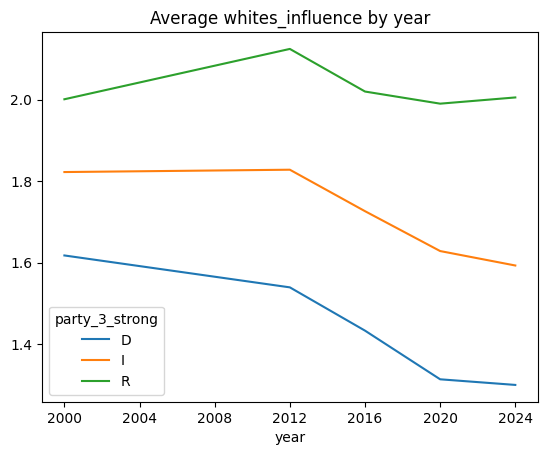

In [23]:
## Compute weighted mean
import matplotlib.pyplot as plt
def weighted_mean(data, val_col, weight="weight"):
    #print(type(data))
    nomiss = data[data[val_col].notna() & data[weight].notna()]
    if len(nomiss) == 0:
        raise ValueError("No valid data to compute weighted mean")
    return (nomiss[val_col] * nomiss[weight]).sum() / nomiss[weight].sum()


## Plot a weighted aggregate function of a variable over time, usually weighted mean, optional grouping
def plot_weight_agg_over_time(
    df,
    var,
    weight = "weight",
    time = "year",
    title = None,
    groupby = None,
    agg = weighted_mean,
):
    nomiss = df[df[var].notna() & df[weight].notna()]
    if groupby is not None:
        for g in groupby:
            nomiss = nomiss[nomiss[g].notna()]
    if len(nomiss) == 0:
        raise ValueError("No valid data to plot")
    
    if groupby is not None:
        nomiss.groupby([time] + groupby).apply(agg, var, weight=weight).unstack().plot()
    else:
        nomiss.groupby(time).apply(agg, var, weight=weight).plot()

    if title is None:
        title = f"Average {var} by {time}"
    plt.title(title)
    plt.xticks(df[time].unique())
    plt.show()

plot_weight_agg_over_time(test, "whites_influence", groupby=["party_3_strong"])

In [73]:
test["weight"]

0                  1.2743
1                  0.9226
2                  1.1215
3                  0.6073
4                  1.9057
               ...       
29321                    
29322    1.79786270502599
29323                    
29324     2.2559355310616
29325    1.29417510337433
Name: weight, Length: 29326, dtype: object

In [3]:
import pandas as pd
def build_dataset(filepath, year, config):
    if filepath.endswith(".dta"):
        raw = pd.read_stata(filepath)
    elif filepath.endswith(".csv"):
        raw = pd.read_csv(filepath, low_memory=False)
    else:
        raise ValueError("Unsupported file format")

    df = raw[[]].copy()
    df["year"] = year
    for var, kwargs in config.items():
        print(var)
        print(kwargs)
        source = kwargs.pop("source")
        type_check = kwargs.pop("type", "int")
        if type_check == "int":
            type_check = int
        elif type_check == "float":
            type_check = float
        elif type_check == "str":
            type_check = str
        else:
            raise ValueError(f"Unsupported type {type_check} for variable {var}")
        kwargs["type_check"] = type_check
        if "mapping" in kwargs:
            mapping = {}
            for k, v in kwargs["mapping"].items():
                try:
                    k2 = int(k)
                except ValueError:
                    k2 = k
                mapping[k2] = v
            kwargs["mapping"] = mapping
        valid = kwargs.pop("valid", None)
        df[var] = map_variable(raw[source], **kwargs)
        if valid is not None:
            if isinstance(valid, list):
                validate_variable(df[var], values=valid)
            else:
                validate_variable(df[var], **valid)

    # Then we would have the calculated ones.
    df["therm_delta"] = df.apply(lambda row: row["therm_whites"] - row["therm_blacks"], axis=1)
    df["age_group"] = df.apply(lambda row: (
        pd.NA if pd.isna(row["age"]) else
        "18-29" if 18 <= int(row["age"]) <= 29 else
        "30-44" if 30 <= int(row["age"]) <= 44 else
        "45-64" if 45 <= int(row["age"]) <= 64 else
        "65+" if int(row["age"]) >= 65 else
        pd.NA
    ), axis=1)
    df["resentment"] = df.apply(lambda row: (
        pd.NA if pd.isna(row["special_favors_plus"]) or pd.isna(row["tried_harder_plus"]) or pd.isna(row["past_slavery_minus"]) or pd.isna(row["less_deserve_minus"]) else
        row["special_favors_plus"] + row["tried_harder_plus"] - row["past_slavery_minus"] - row["less_deserve_minus"]
    ), axis=1)
    validate_variable(df["resentment"], min=-8, max=8)
    df["race_edu_block"] = df.apply(lambda row: (
        pd.NA if pd.isna(row["college"]) or pd.isna(row["race"]) else
        "NonWhite" if row["race"] in ("Black","Hispanic","Other") else
        "WhiteCollege" if row["race"] == "White" and row["college"] == 1 else
        "WhiteNonCollege" if row["race"] == "White" and row["college"] == 0 else
        pd.NA
    ), axis=1)
    df["race_edu_block"] = df.apply(lambda row: (
        pd.NA if pd.isna(row["college"]) or pd.isna(row["race"]) else
        "NonWhite" if row["race"] in ("Black","Hispanic","Other") else
        "WhiteCollege" if row["race"] == "White" and row["college"] == 1 else
        "WhiteNonCollege" if row["race"] == "White" and row["college"] == 0 else
        pd.NA
    ), axis=1)
    df["race_party_block"] = df.apply(lambda row: (
        pd.NA if pd.isna(row["race"]) or pd.isna(row["republican"]) or pd.isna(row["democrat"]) else
        "WhiteRep" if row["race"] == "White" and row["republican"] == 1 else
        "WhiteDem" if row["race"] == "White" and row["democrat"] == 1 else
        "WhiteInd" if row["race"] == "White" else
        "NonWhite" if row["race"] in ("Black","Hispanic","Other") else
        pd.NA
    ), axis=1)
    df["vote_prev_vote"] = df.apply(lambda row: (
        pd.NA if pd.isna(row["prev_rep_pres"]) or pd.isna(row["vote_rep_pres"]) else
        "Rep-Rep" if row["prev_rep_pres"] == 1 and row["vote_rep_pres"] == 1 else
        "Rep-Dem" if row["prev_rep_pres"] == 1 and row["vote_rep_pres"] == 0 else
        "Dem-Rep" if row["prev_rep_pres"] == 0 and row["vote_rep_pres"] == 1 else
        "Dem-Dem" if row["prev_rep_pres"] == 0 and row["vote_rep_pres"] == 0 else
        pd.NA
    ), axis=1)
    df = df[~df["weight"].isna()]
    return df

df = build_dataset("raw/anes_timeseries_2024_csv_20250808.csv", 2024, year_2024)

weight
{'source': 'V240107b', 'type': 'float', 'valid': {'min': 0}}
age
{'source': 'V241458x', 'nulls': [-2], 'valid': {'min': 0, 'max': 120}}
female
{'source': 'V241550', 'nulls': [3, 0, -9], 'mapping': {'1': 0, '2': 1}, 'valid': [0, 1]}
race
{'source': 'V241501x', 'nulls': [-4, -8, -9], 'mapping': {'1': 'White', '2': 'Black', '3': 'Hispanic', '4': 'Other', '5': 'Other', '6': 'Other'}, 'type': 'str', 'valid': ['White', 'Black', 'Hispanic', 'Other']}
strong_republican
{'source': 'V241227x', 'mapping': {'1': 0, '2': 0, '3': 0, '4': 0, '5': 0, '6': 0, '7': 1}, 'valid': [0, 1]}
republican
{'source': 'V241227x', 'mapping': {'1': 0, '2': 0, '3': 0, '4': 0, '5': 0, '6': 1, '7': 1}, 'valid': [0, 1]}
lean_republican
{'source': 'V241227x', 'mapping': {'1': 0, '2': 0, '3': 0, '4': 0, '5': 1, '6': 1, '7': 1}, 'valid': [0, 1]}
strong_democrat
{'source': 'V241227x', 'mapping': {'1': 1, '2': 0, '3': 0, '4': 0, '5': 0, '6': 0, '7': 0}, 'valid': [0, 1]}
democrat
{'source': 'V241227x', 'mapping': {'1':

In [37]:
test["whites_influence"].value_counts(dropna=False)

whites_influence
2       12541
1        8473
NaN      3534
<NA>     3388
3        1390
Name: count, dtype: int64